## More Tests
### 2024.08.08

We adjusted the way in which beta is updated. 
At each time step, beta is updated according to an OU process *before* the state vector is updated. 
That way, there is variation in all particles' beta values, even if they were resampled from the same particle at
the previous time step.

[0.25       0.2474359  0.24487179 0.24230769 0.23974359 0.23717949
 0.23461538 0.23205128 0.22948718 0.22692308 0.22435897 0.22179487
 0.21923077 0.21666667 0.21410256 0.21153846 0.20897436 0.20641026
 0.20384615 0.20128205 0.19871795 0.19615385 0.19358974 0.19102564
 0.18846154 0.18589744 0.18333333 0.18076923 0.17820513 0.17564103
 0.17307692 0.17051282 0.16794872 0.16538462 0.16282051 0.16025641
 0.15769231 0.15512821 0.1525641  0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15       0.15
 0.15       0.15       0.15       0.15       0.15

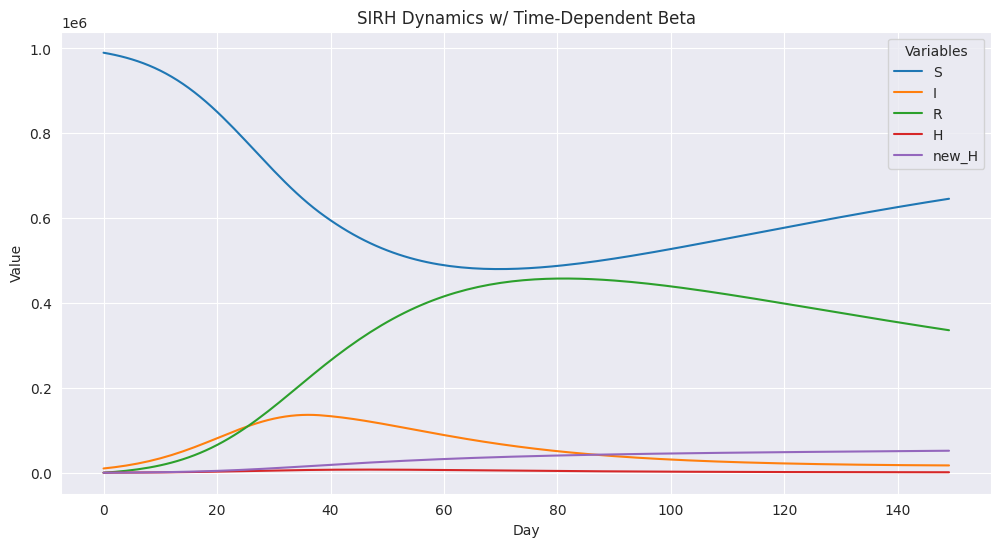

In [1]:
from src.particle_filter.parameters import ModelParameters
from src.particle_filter.transition import (
    Transition,
    OUModel,
)
from jax.random import PRNGKey
import jax.numpy as jnp
import numpy as np

days = 150
step_beta_switch = 40

initial_beta = 0.25
final_beta = 0.15

# Create a linear decline from initial_beta to final_beta
linear_decline = np.linspace(initial_beta, final_beta, step_beta_switch)

# Combine the declining part with the final constant value
step_beta = np.concatenate([linear_decline, [final_beta] * (days - step_beta_switch)])

pop = 1000000
infected = 0.01 * pop
susceptible = pop - infected
initial_state = jnp.array([susceptible, infected, 0, 0, 0, 0.3])
key = PRNGKey(0)
print(step_beta)
import paths
import os

config_path = os.path.join(paths.PF_DIR, "config.toml")

ou_model = OUModel(config_path)

det_output = [initial_state.copy()]
case_reports = [0]


def det_update(state, time_step):
    state = state.at[5].set(step_beta[time_step])
    update = ou_model.det_component(state, time_step)
    case_reports.append(update[4].item())
    state += update
    return state


for t in range(1, days):
    det_output.append(det_update(det_output[-1], t))
import numpy as np
import matplotlib.pyplot as plt


def plot_output(output):
    data = np.array(output)
    labels = ["S", "I", "R", "H", "new_H"]
    # Create a plot for each variable
    plt.figure(figsize=(12, 6))

    # for each day
    for i in range(data.shape[1] - 1):
        # plot each compartment
        plt.plot(range(data.shape[0]), data[:, i], label=labels[i])

    plt.title("SIRH Dynamics w/ Time-Dependent Beta")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend(title="Variables")
    plt.show()


plot_output(det_output)

## Estimating the system with our Particle Filter

We run a PF over the generated data. Settings were configured in `config.toml`.

**On this run, we decreased the likelihood variance.
This results in more discrepancies in the weights, and more "bad" particles being
thrown away at each resample step.**

- Beta prior = uniform draw from [0.1, 0.3]
- Number of particles = 500
- dt = 1.0
- infected compartment prior: uniform draw from [1, 0.03 * population]
- normal logpdf likelihood with variable scale (20% of average particle estimate)
- dW_volatility = {value = 0.008, is_fixed = true}

#### Beta OU Params
- beta_theta = {value = 0.05, is_fixed = true}
- beta_mu = {value = 0.15, is_fixed = true}
- beta_sigma = {value=0.005, is_fixed = true}

Note that we are 'cheating' here by setting the beta_mu to the final actual beta values. 
However, this makes it clear that a good prior will improve results. 
We should work to find a good method for determining prior values for OU parameters. 

In [2]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(
    state_population=pop, location_code="04", target_date="2047-10-28", runtime=days
)

In [3]:
hosp_estimates, states, all_resamples, all_weights = pf_algo.run(
    observation_data=case_reports
)

Running Particle Filter: 100%|██████████| 150/150 [14:15<00:00,  5.70s/it]


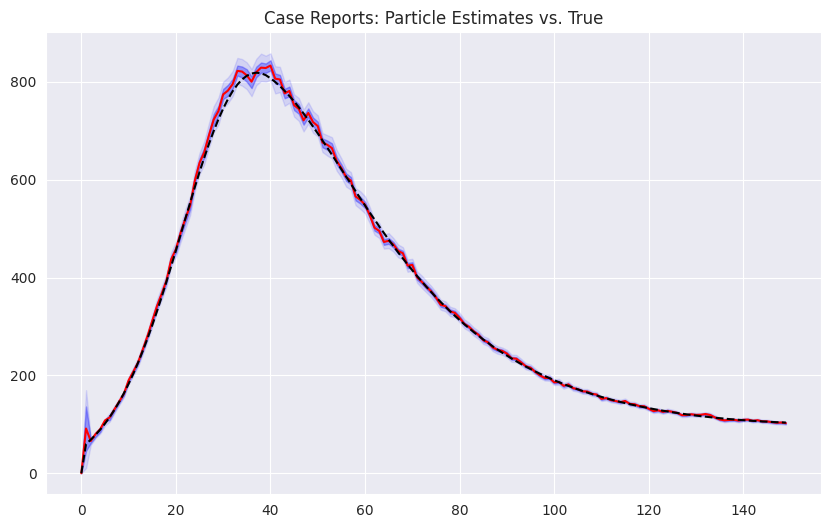

In [4]:
true_data = np.array(det_output)
true_data = true_data.T
true_data[5, :] = step_beta
true_data.shape
# Number of particles, state variables, and time steps
N, S, T = states.shape

state_labels = ["S", "I", "R", "H", "new_H", "beta"]

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
quantile_hosp_estimates = np.percentile(
    hosp_estimates, [q * 100 for q in quantiles], axis=0
)
plt.figure(figsize=(10, 6))
plt.title("Case Reports: Particle Estimates vs. True")
plt.fill_between(
    np.arange(T),
    quantile_hosp_estimates[0],
    quantile_hosp_estimates[-1],
    color="blue",
    alpha=0.1,
)
plt.fill_between(
    np.arange(T),
    quantile_hosp_estimates[1],
    quantile_hosp_estimates[-2],
    color="blue",
    alpha=0.3,
)
plt.plot(np.arange(T), quantile_hosp_estimates[2], color="red")  # Median
plt.plot(np.arange(T), case_reports, color="black", linestyle="--")  # true data

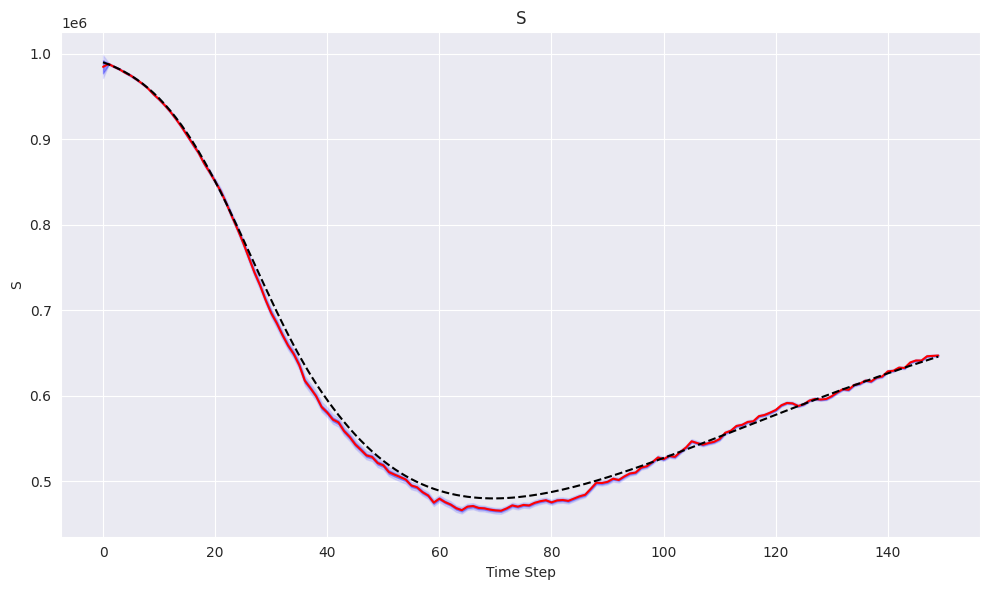

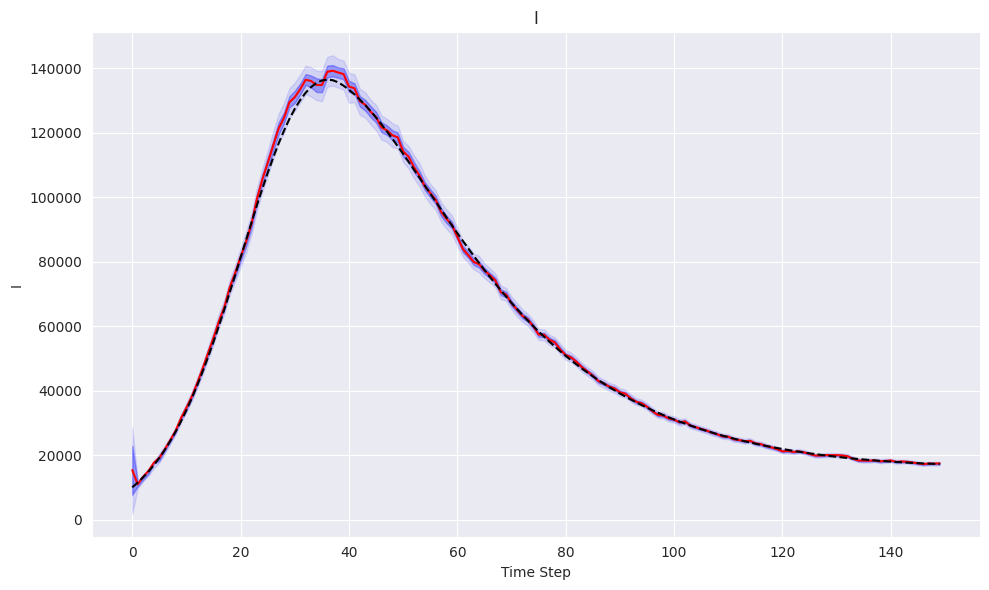

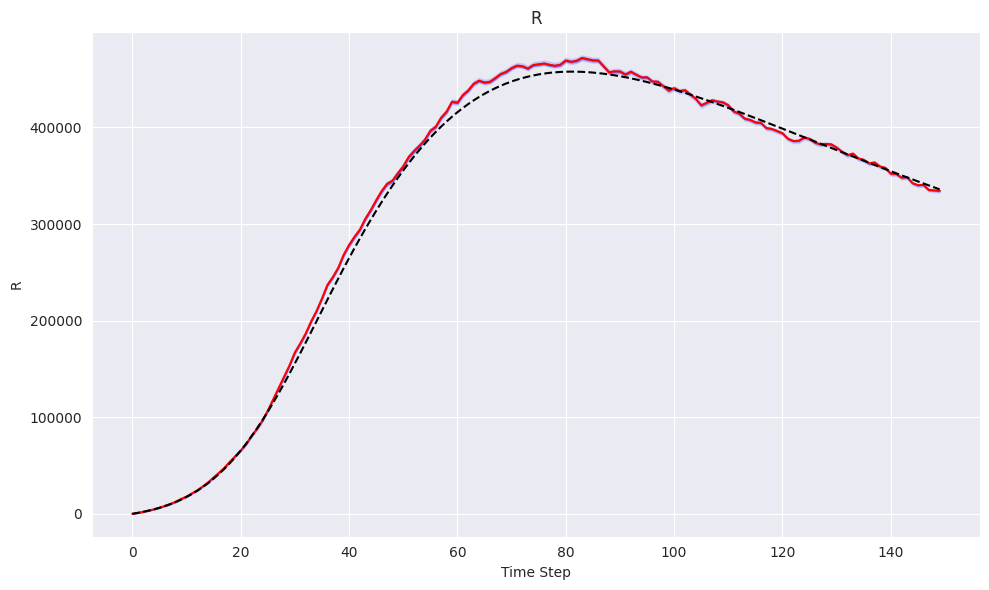

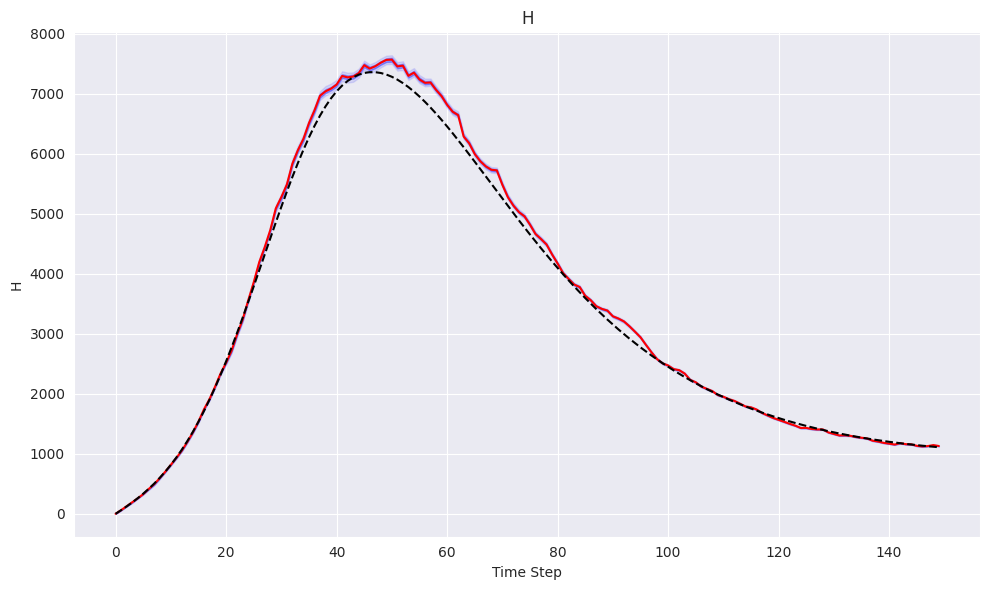

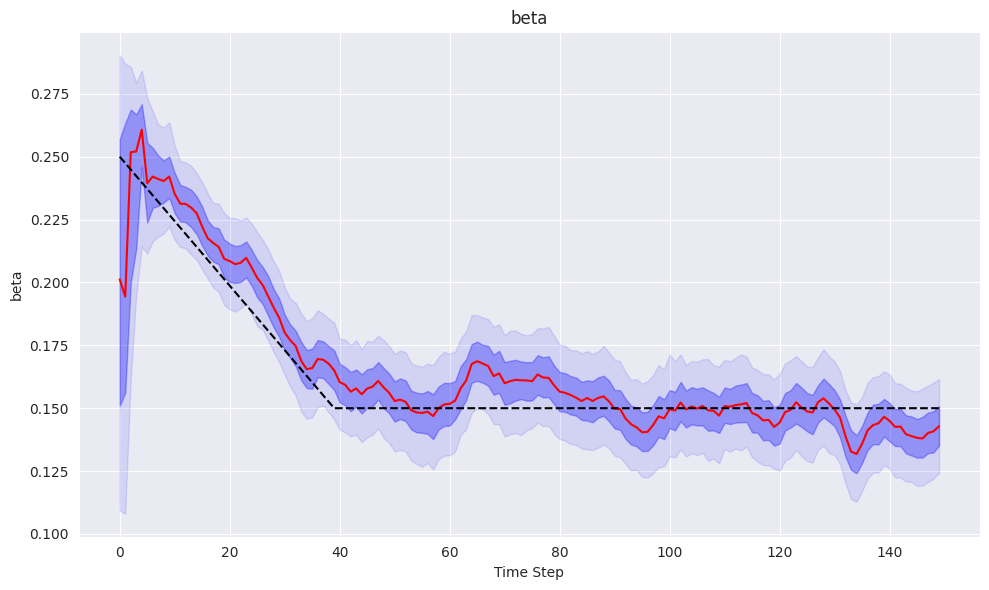

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot each state variable separately
for i in range(S):
    if i == 4:  # ignore new_H compartment
        continue

    variable_data = states[:, i, :]  # Shape (N, T)

    quantile_values = np.percentile(variable_data, [q * 100 for q in quantiles], axis=0)

    plt.figure(figsize=(10, 6))

    # Fill areas between quantiles
    plt.fill_between(
        np.arange(T), quantile_values[0], quantile_values[-1], color="blue", alpha=0.1
    )
    plt.fill_between(
        np.arange(T), quantile_values[1], quantile_values[-2], color="blue", alpha=0.3
    )
    plt.plot(np.arange(T), quantile_values[2], color="red")  # Median
    plt.plot(np.arange(T), true_data[i, :], color="black", linestyle="--")  # true data

    plt.title(state_labels[i])
    plt.xlabel("Time Step")
    plt.ylabel(state_labels[i])

    plt.tight_layout()
    plt.show()
    plt.close()